<IPython.core.display.Javascript object>


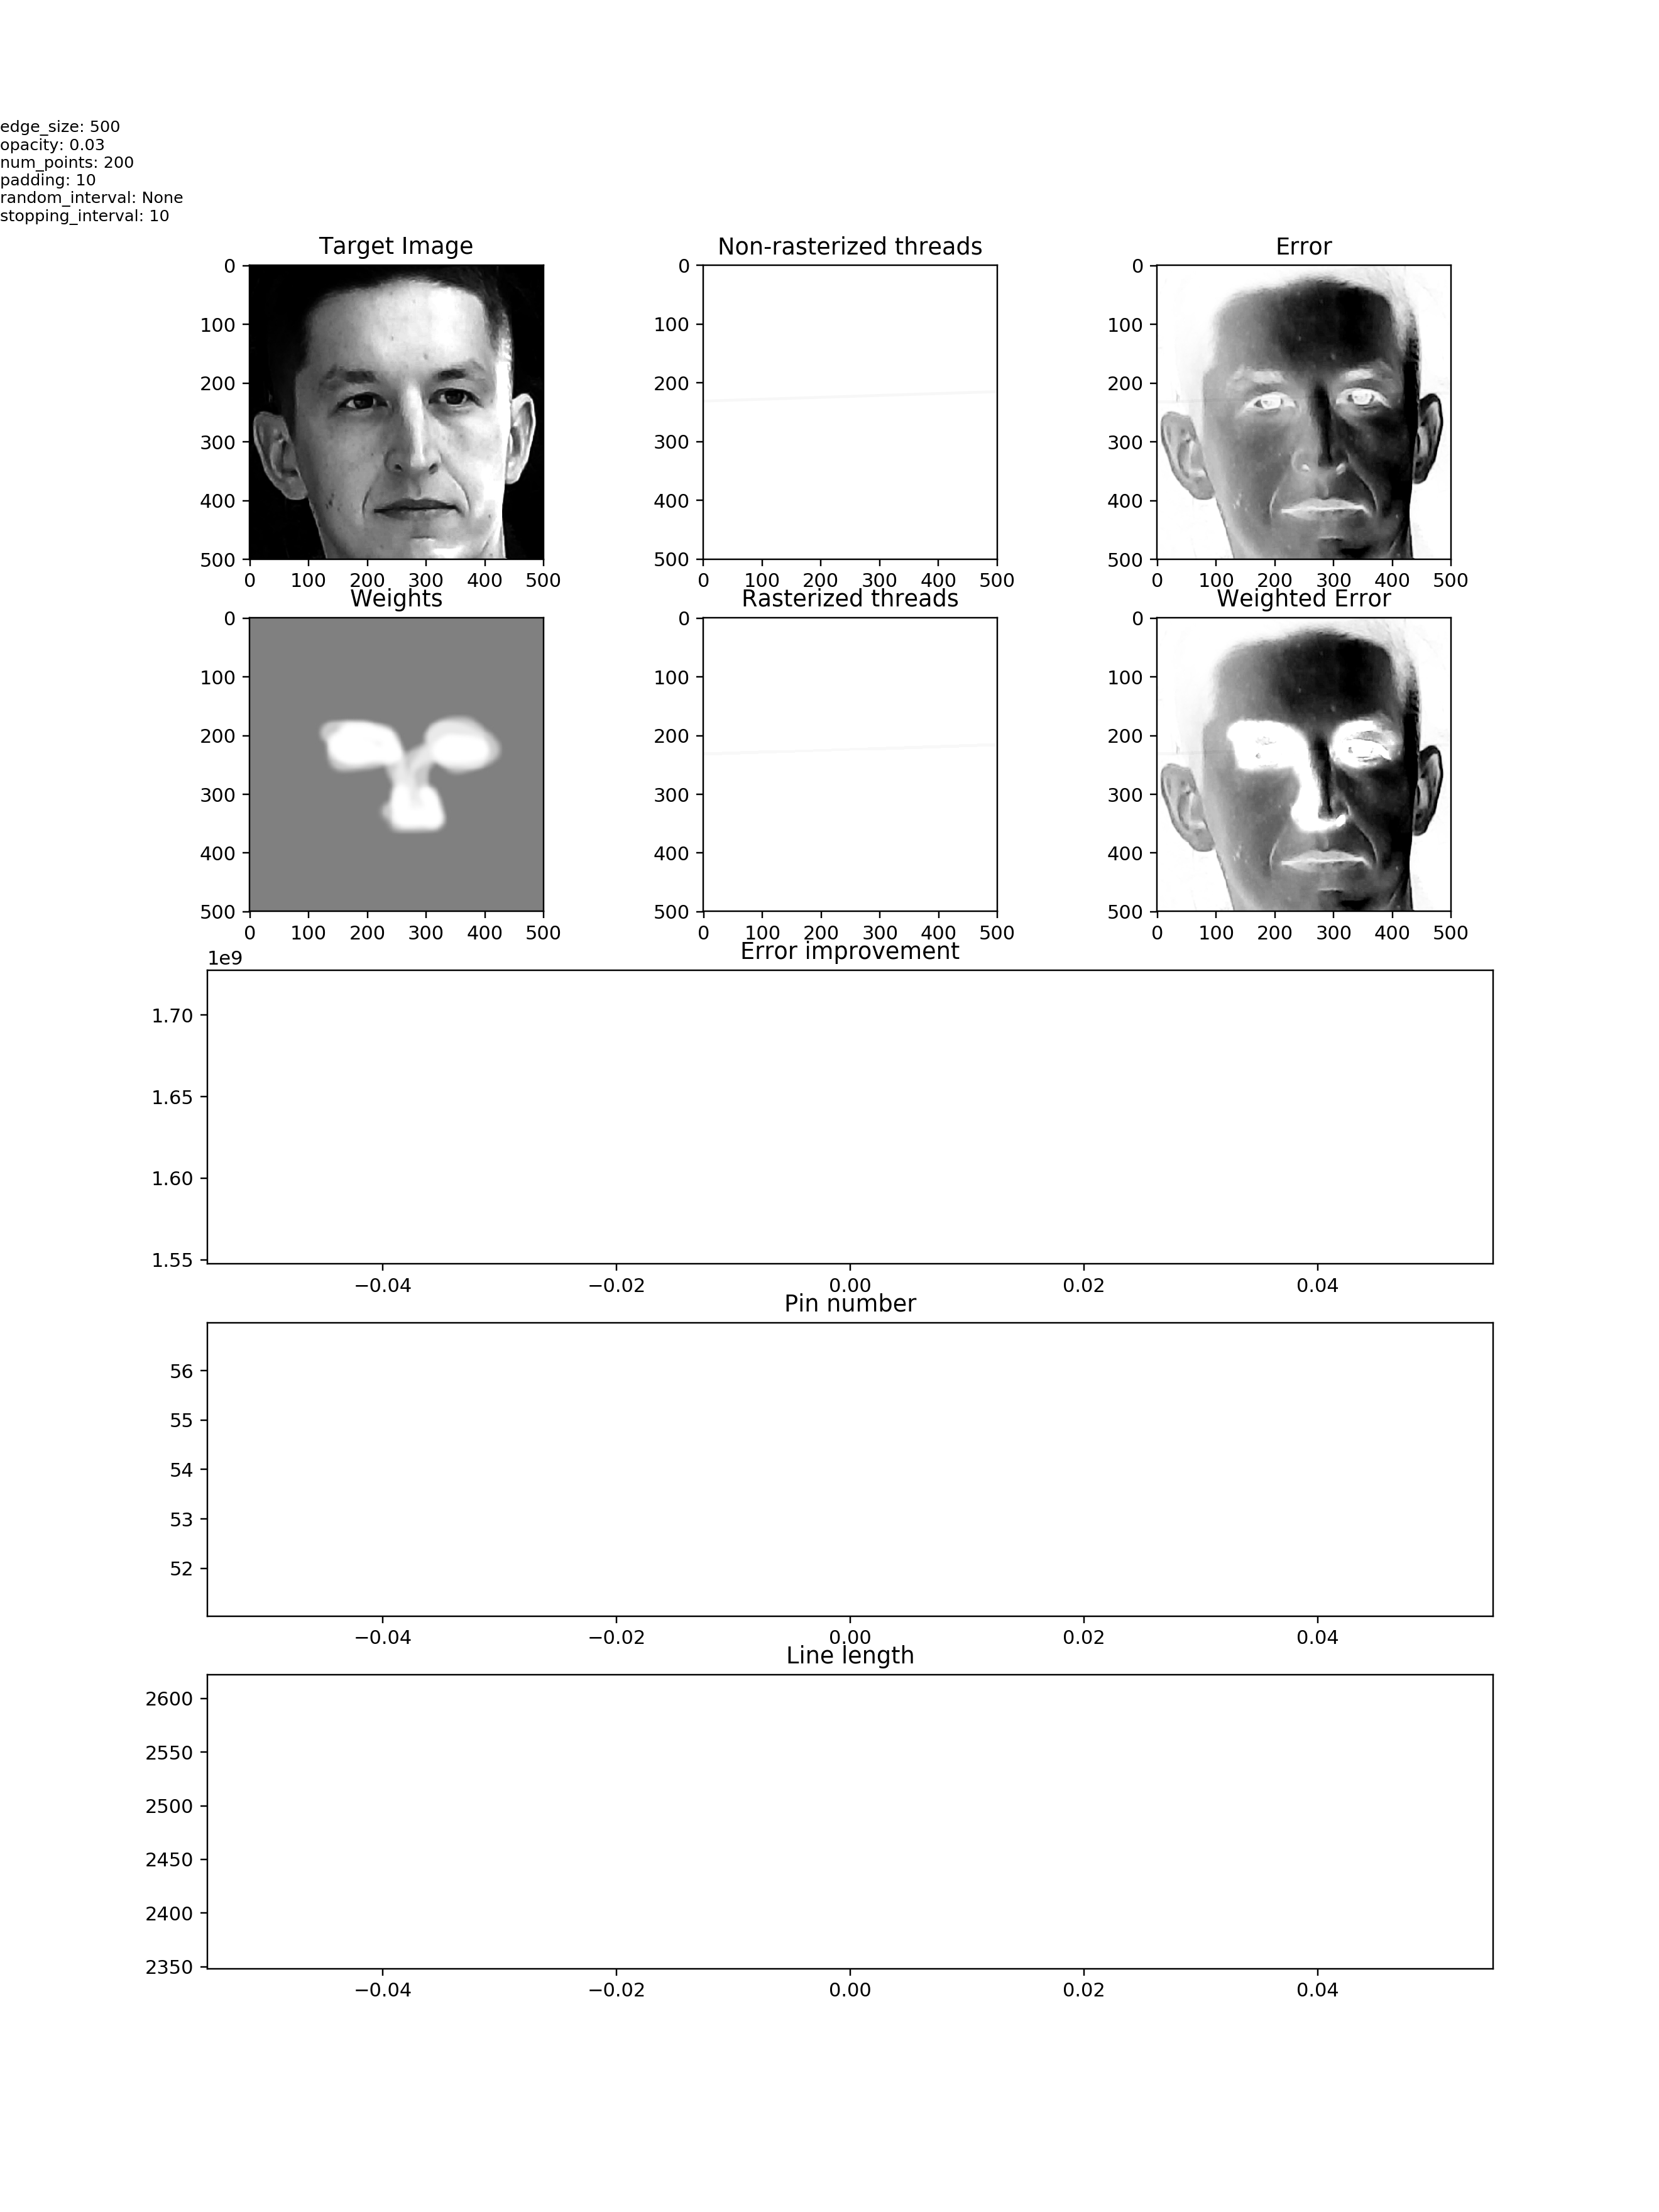

Finished! We drew 10 lines


In [6]:
import matplotlib.image as mpimg
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
from bresenham import bresenham
from scipy import ndimage
from scipy.misc import imresize
from random import randint
import pickle

%matplotlib nbagg

edge_size = 500
line_opacity = .03
num_points = 200
padding = 10
random_interval = None
stopping_lookback = 10
LOOKAHEAD = 0

# Circle Points
theta = np.linspace(0, 2*np.pi, num_points)
a, b = edge_size * (np.cos(theta)+1)/2-1, edge_size * (np.sin(theta)+1)/2-1
points = zip([int(i) for i in a],[int(i) for i in b])

def get_image(f='./nerea1.jpg'):
    img = ndimage.imread(f, flatten=True)
    return img

class Plot():
    def __init__(self, img, weights):
        self.fig = plt.figure(figsize=(12, 16))
        figtext = "edge_size: {0}\nopacity: {1}\nnum_points: {2}\npadding: {3}\nrandom_interval: {4}\nstopping_interval: {5}".format(edge_size, line_opacity, num_points, padding, random_interval, stopping_lookback)
        plt.figtext(0, 0.9, figtext, color='black', weight='roman',
            size='small')

        self.ax1 = plt.subplot2grid((5, 3), (0, 0))
        self.ax1.set_title("Target Image")
        
        self.ax8 = plt.subplot2grid((5, 3), (1, 0))
        self.ax8.set_title("Weights")
        
        self.ax2 = plt.subplot2grid((5, 3), (0, 1))
        self.ax2.set_title("Non-rasterized threads")
        self.ax2.set_xlim([0, edge_size])
        self.ax2.set_ylim([edge_size, 0])
        self.ax2.set_aspect('equal')
        
        self.ax3 = plt.subplot2grid((5, 3), (1, 1))
        self.ax3.set_title("Rasterized threads")
        
        self.ax4 = plt.subplot2grid((5, 3), (0, 2))
        self.ax4.set_title("Error")
        
        self.ax9 = plt.subplot2grid((5, 3), (1, 2))
        self.ax9.set_title("Weighted Error")
        
        self.ax5 = plt.subplot2grid((5, 3), (2, 0), colspan=3)
        self.ax5.set_title("Error improvement")
        
        self.ax6 = plt.subplot2grid((5, 3), (3, 0), colspan=3)
        self.ax6.set_title("Pin number")
        
        self.ax7 = plt.subplot2grid((5, 3), (4, 0), colspan=3)
        self.ax7.set_title("Line length")
        self.last_line = 0
        self.ax1.imshow(img, cmap="gray", vmin=0, vmax=255)
        self.ax8.imshow(weights, cmap="gray", vmin=0, vmax=255)
        
        #self.fig.subplots(figsize=(20, 10))
        #plt.tight_layout()

    def show(self, weights, raster, diff, points_log,errors, pins, lengths):
        self.ax9.imshow(np.multiply(weights/128,diff), cmap="gray", vmin=0, vmax=255)
        #lc = LineCollection([points_log[-1]], linewidths=2, alpha=0.01)
        #self.ax2.add_collection(lc)
        for i in xrange(self.last_line, len(points_log)-1):
            line_x = [points[points_log[i]][0], points[points_log[i+1]][0]]
            line_y = [points[points_log[i]][1], points[points_log[i+1]][1]]
            self.ax2.plot(line_y, line_x, alpha=line_opacity, color="k")
        #self.ax2.plot(*zip(*points), 'b.')
        self.ax3.imshow(raster, cmap="gray", vmin=0, vmax=255)
        self.ax4.imshow(diff, cmap="gray", vmin=0, vmax=255)
        self.fig.canvas.draw()
        self.ax5.plot(range(self.last_line,len(points_log)-1),errors[self.last_line:])
        self.ax6.plot(range(self.last_line,len(points_log)-1),pins[self.last_line:-1])
        self.ax7.plot(range(self.last_line,len(points_log)-1),lengths[self.last_line:])        
        self.last_line = len(points_log)
    
def get_next_point(prev,diff,weights,lookahead=0):
    best_score = None
    starting_point =  points[prev[-1]]
    if random_interval!=None and randint(1, random_interval)==1:
        choose_a_random_point = True
        random_i = randint(0, len(points)-1)
    else:
        choose_a_random_point = False
    for i, proposed_point in enumerate(points):
        if (prev[-1]-i)%num_points < padding or (prev[-1]-i)%num_points > num_points - padding: continue        
        if (len(prev)>1 and prev[-2]==i): continue
        proposed_line = get_line_pixels(starting_point,proposed_point,thickness = 1)
        score = 0 
        l1=0
        l2=0
        
        # calculate score
        for pixel in proposed_line:
            l1+=0#diff[point] * 10
            l2+=diff[pixel]**2 * np.sign(diff[pixel])
            score += weights[pixel] * (l1 + l2)
        score = float(score)/len(proposed_line)
        if lookahead>0:
            score += get_next_point([prev[-1],i],diff,weights,lookahead=lookahead-1)[1]
            
        if ((choose_a_random_point and i==random_i) or 
            best_score is None or 
            score>best_score):
            best_i=i
            best_score = score
            best_l1  = float(l1) / len(proposed_line)
            best_l2  = float(l2) / len(proposed_line)
            
        if choose_a_random_point and i==random_i:
            break
    #print best_i
    return best_i, best_score, best_l1, best_l2, choose_a_random_point

def get_line_pixels(p1,p2,thickness = 5):
    line_points = []
    line_px = list(bresenham(p1[0], p1[1], p2[0], p2[1]))
    for px in line_px:
        if abs(p1[0]-p2[0])>abs(p1[1]-p2[1]):
            for j in xrange(thickness):
                if px[1]+j>=edge_size:
                    break
                line_points.append((px[0],px[1]+j))
        else:
            for j in xrange(thickness):
                if px[0]+j>=edge_size:
                    break
                line_points.append((px[0]+j,px[1]))
    return line_points

def draw_line(img,pixels):
    for pixel in pixels:
        img[pixel[0],pixel[1]] = max(img[pixel[0],pixel[1]] * (float(1)-line_opacity),0)

def update_diff(diff, raster, img, pixels):
    for pixel in pixels:
        diff[pixel] = raster[pixel] - img[pixel]
    
def main():
    original_img = get_image('/Users/delbalso/Downloads/dave.jpg')
    img = original_img
    img = imresize(((img - img.min())/img.max()*255).astype('uint8'),(edge_size, edge_size)).astype('float32')
    original_weights = get_image('/Users/delbalso/Downloads/dave-mask.jpg')
    weights = imresize(original_weights.astype('uint8'),(edge_size, edge_size)).astype('float32')
    p = Plot(img, weights)
    
    # Raster is the image we're drawing to simulate thread
    raster = np.zeros((edge_size, edge_size))+255
    assert raster.shape == img.shape
    i = 0
    diff = np.subtract(raster, img)
    errors = []
    lengths = []
    points_log = [randint(0, len(points)-1)]
    while (len(errors)<stopping_lookback or 
           sum(errors[-stopping_lookback:]) > stopping_lookback*0.125):
        next_point, err, l1, l2, random_point = get_next_point(points_log[-1:],diff,weights,LOOKAHEAD)
        #if random_point: print "random point chosen on {}".format(i)
        points_log.append(next_point)
        errors.append(err)
        
        line_pixels = get_line_pixels(points[points_log[-2]],points[points_log[-1]])
        lengths.append(len(line_pixels))
        draw_line(raster,line_pixels)
        update_diff(diff, raster, img, line_pixels)
        
        if i%100==0: p.show(weights,raster,diff,points_log, errors, points_log, lengths) 
        i = i+1

    pickle.dump({"point_log": points_log,
                 "image": original_img,
                 "weights": original_weights,
                 "figure": p},
                open( "save.p", "wb" ))
    p.fig.savefig('results.png')  
    print "Finished! We drew {0} lines".format(i)

if __name__ == "__main__":
    main()